In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 1024  # object size in x,y
nz = 1024  # object size in z    
ntheta = 1  # number of angles (rotations)

pnz = nz # tomography chunk size for GPU processing (dont change if data is small and fits gpu memory)
ptheta = ntheta # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.28 # [m]
ncodes = 4
sx0 = 3.7e-4 # [m] motor offset from the focal spot
z1 = np.tile(np.array([4.584e-3]),ncodes)-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
#magnifications = magnifications*0+1
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distancesc due to magnified probes

## Read real and imaginary parts of the refractive index u = delta+i beta

In [3]:
img = np.zeros((n, n, 3), np.uint8)
triangle = np.array([(n//16, n//2-n//32), (n//16, n//2+n//32), (n//2-n//32, n//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((n, n, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-n//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+n//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
x = x/n*2
y = y/n*2
# add holes in triangles
circ = (x**2+y**2>0.385)+(x**2+y**2<0.365)
circ *= (x**2+y**2>0.052)+(x**2+y**2<0.05)
star = star*circ/255
#slightly smooth
# v = np.arange(-n//2,n//2)/n
# [vx,vy] = np.meshgrid(v,v)
# v = np.exp(-20*(vx**2+vy**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
# star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

29.999999999999996

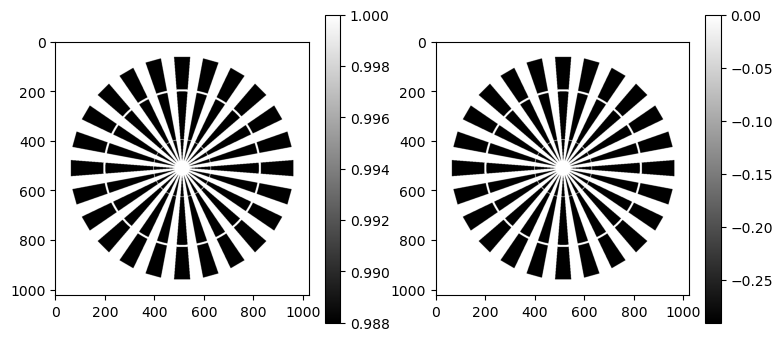

In [4]:
import xraylib
delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)
# delta = 1-xraylib.Refractive_Index_Re('(C5O2H8)n',energy,1.18)
# beta = xraylib.Refractive_Index_Im('(C5O2H8)n',energy,1.18)

thickness = 600e-9/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength)[np.newaxis].astype('complex64')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
fig.colorbar(im)
thickness

Note that in this formation delta is negative

## Create a solver class for holography

In [5]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Read a reference images (probe) recovered by the NFP method at ID16A. 

In [6]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0]
prb0 = np.zeros([ncodes,nz,n],dtype='complex64')
prb0[:] = prb_abs*np.exp(1j*prb_phase)  


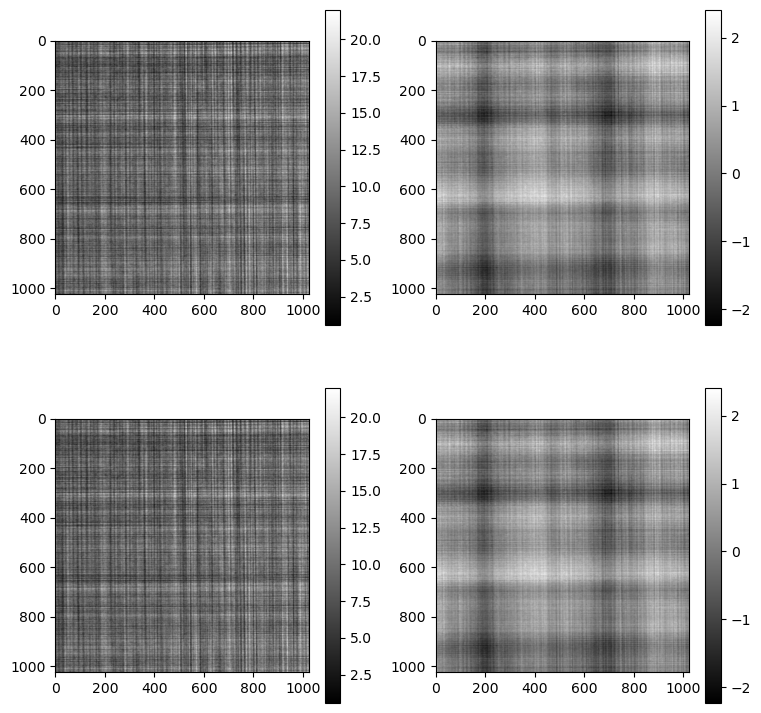

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(prb0[0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(prb0[0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(prb0[-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb0[-1]),cmap='gray')
fig.colorbar(im)

# Structured illuminations

ill_feature_size=2.56e-06m
(4, 1024, 1024)


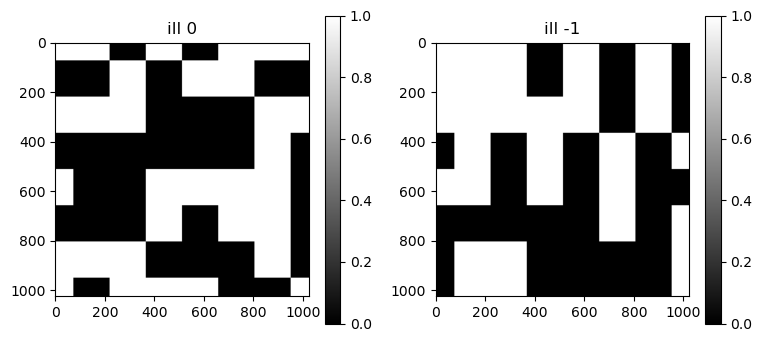

In [8]:
import random
import scipy.ndimage as ndimage
nill = n//128
ill_feature_size = n/nill*voxelsize

print(f'{ill_feature_size=}m')


ill = np.zeros([ncodes,nill,nill],dtype=np.int32)
for k in  range(ill.shape[0]):
    ill0 = np.zeros([nill*nill],dtype=np.int32)
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill[k] = ill0.reshape(nill,nill)
ill = ndimage.zoom(ill,[1,n/nill,n/nill],order=0)
print(ill.shape)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(ill[0],cmap='gray')
axs[0].set_title('ill 0')
fig.colorbar(im)
im=axs[1].imshow(ill[1],cmap='gray')
axs[1].set_title('ill -1')
fig.colorbar(im)



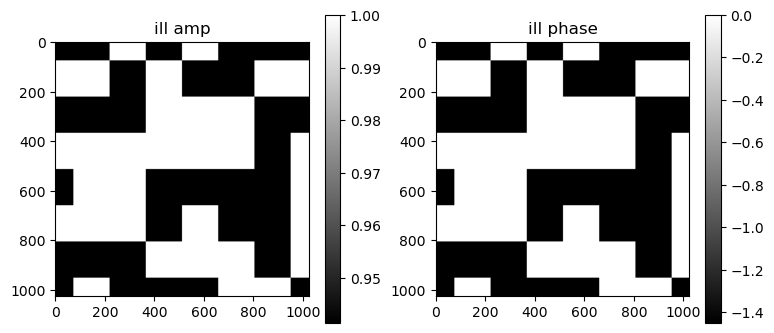

In [17]:
import xraylib
delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)
# delta = 1-xraylib.Refractive_Index_Re('(C5O2H8)n',energy,1.18)
# beta = xraylib.Refractive_Index_Im('(C5O2H8)n',energy,1.18)
thickness = 3*1e-6/voxelsize # thickness in pixels
# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = np.exp(1j * Rill * voxelsize * 2 * np.pi / pslv.wavelength()).astype('complex64')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0]),cmap='gray')
axs[0].set_title('ill amp')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0]),cmap='gray')
axs[1].set_title('ill phase')
fig.colorbar(im)

# Multiply probe by illuminations

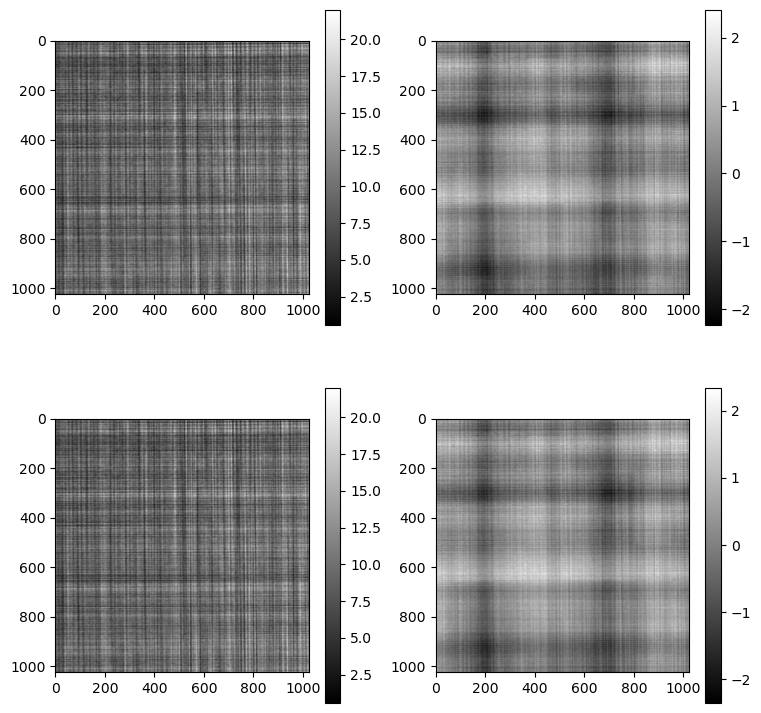

In [16]:
prb = prb0*psiill#*0+1
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(prb[-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb[-1]),cmap='gray')
fig.colorbar(im)


# Compute holographic projections for all angles and all distances

In [11]:
fpsi = pslv.fwd_holo_batch(psi,prb)

## Take squared absolute value to simulate data on the detector, flat fields, and data with homogeneous flat fields  

In [12]:
data = np.abs(fpsi)**2

0.0043029757

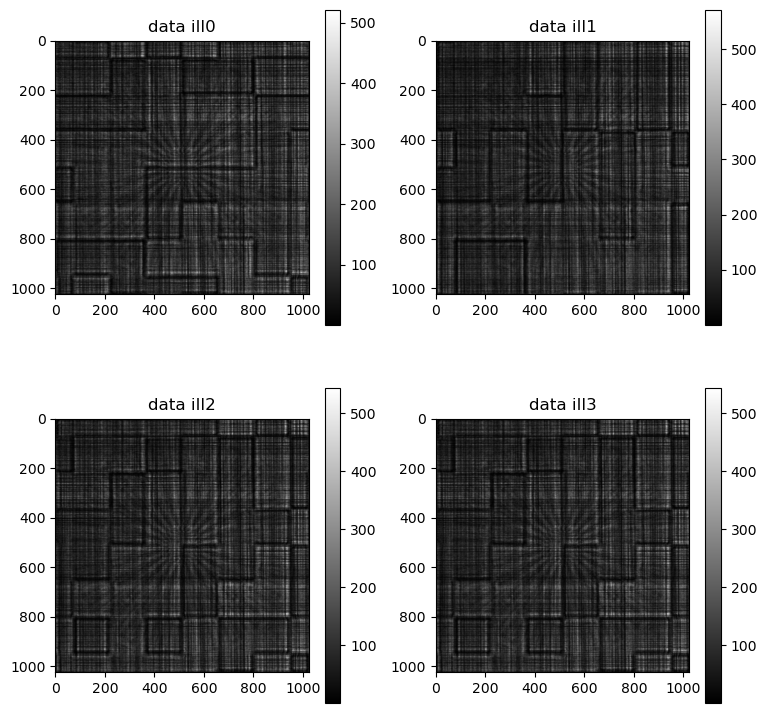

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data ill0')
fig.colorbar(im)

im=axs[0,1].imshow(data[1,0],cmap='gray')
axs[0,1].set_title('data ill1')
fig.colorbar(im)

im=axs[1,0].imshow(data[2,0],cmap='gray')
axs[1,0].set_title('data ill2')
fig.colorbar(im)

im=axs[1,1].imshow(data[2,0],cmap='gray')
axs[1,1].set_title('data ill3')
fig.colorbar(im)

np.min(data[0,0])

# Save data nd flat fields

In [14]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'data/modeling/data_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(np.abs(prb[k]),f'data/modeling/prb_amp_{n}_{k}',overwrite=True)
    dxchange.write_tiff(np.angle(prb[k]),f'data/modeling/prb_angle_{n}_{k}',overwrite=True)
dxchange.write_tiff(np.abs(psi[0]),f'data/modeling/psi_amp_{n}',overwrite=True)
dxchange.write_tiff(np.angle(psi[0]),f'data/modeling/psi_angle_{n}',overwrite=True)